In [1]:
#Import relevant libraries

import warnings
import itertools
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
yf.pdr_override()
from datetime import datetime
import seaborn as sns
import cufflinks
import plotly
from plotly.plotly import plot_mpl


#defaults

plt.style.use('fivethirtyeight')

In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
yf.pdr_override()

from datetime import datetime
import seaborn as sns

import cufflinks
import plotly
from plotly.plotly import plot_mpl

In [7]:
#Use Power Assets Holdings Ltd as an example

stock = "0006"
stock = f"{stock}.HK"
stock

'0006.HK'

[*********************100%***********************]  1 of 1 downloaded


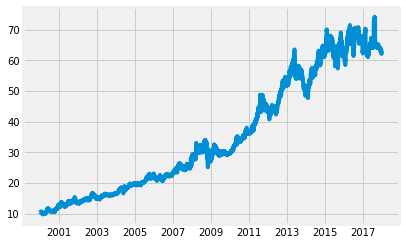

In [8]:
#Load data

start = datetime(2000,1,4)
end = datetime(2017,12,31)

ticker = data.get_data_yahoo(stock, start, end)
ticker.head()

df = pd.DataFrame(index=ticker.index)
df['Adj Close'] = ticker['Adj Close']

#Plot data

plt.plot(df["Adj Close"], label = "Adj Close")

In [14]:
data = df
data.index = pd.to_datetime(data.index)

In [15]:
#Group price data by monthly average

data = data['Adj Close'].resample('MS').mean()
data = data.fillna(data.bfill())


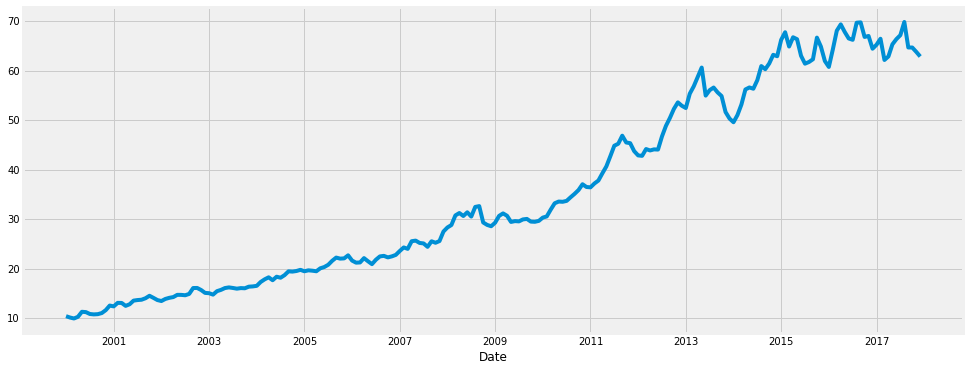

In [16]:
#plot data

data.plot(figsize=(15, 6))
plt.show()

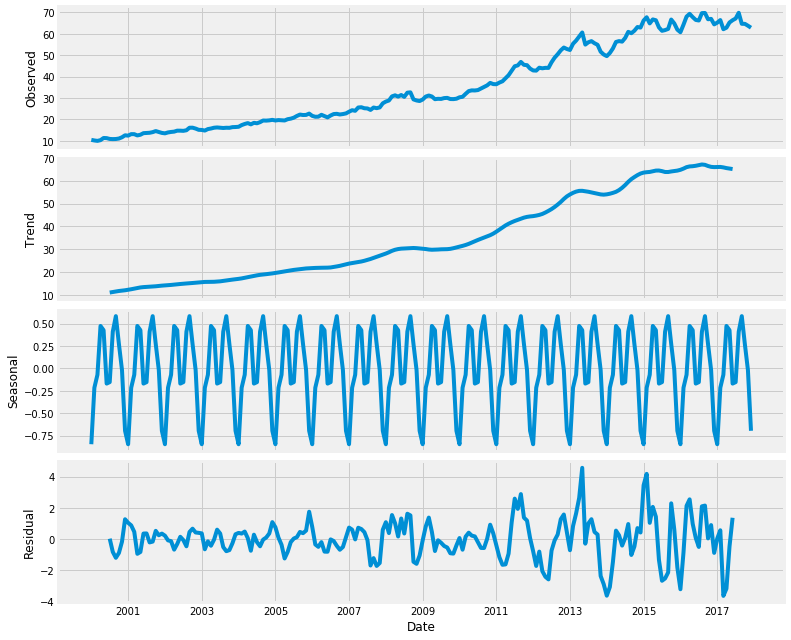

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2209.5811326903445
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1974.5428815107168
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1247.1911406298423
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1243.88716799137
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1239.0911343246287
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1191.0735702364987
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1920.977542046641
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1687.1136497108582
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1025.3400335814404
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1024.9241061187633
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1022.9435051443633
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:986.0385799101889
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:744.5985228936348
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:746.0350245589159
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:824.1478018813061
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:716.5791917164563
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:745.7411790176043
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:737.3048492430545
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:736

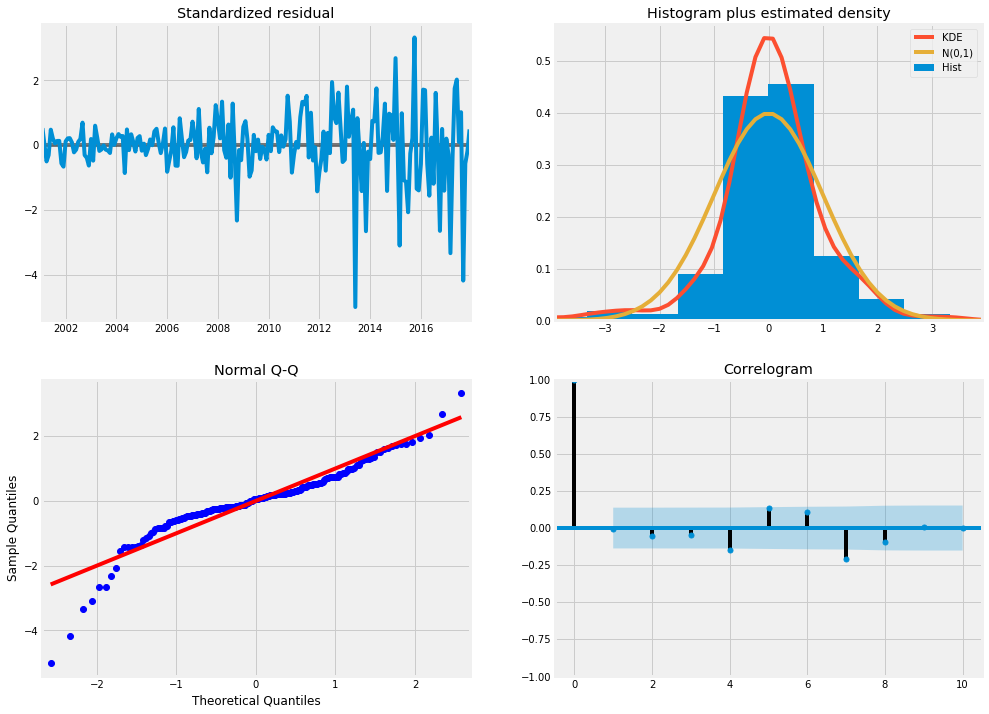

In [19]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append 는 일반 list append 와 다르게 이렇게 지정해주어야한다.
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(data,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [20]:
#parameters that provide lowest AIC score is adopted

mod = sm.tsa.statespace.SARIMAX(data,
                                order=(0,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1354      0.080      1.698      0.090      -0.021       0.292
ar.S.L12      -0.2977      0.073     -4.101      0.000      -0.440      -0.155
ma.S.L12      -0.6359      0.069     -9.275      0.000      -0.770      -0.502
sigma2         1.7479      0.098     17.792      0.000       1.555       1.940


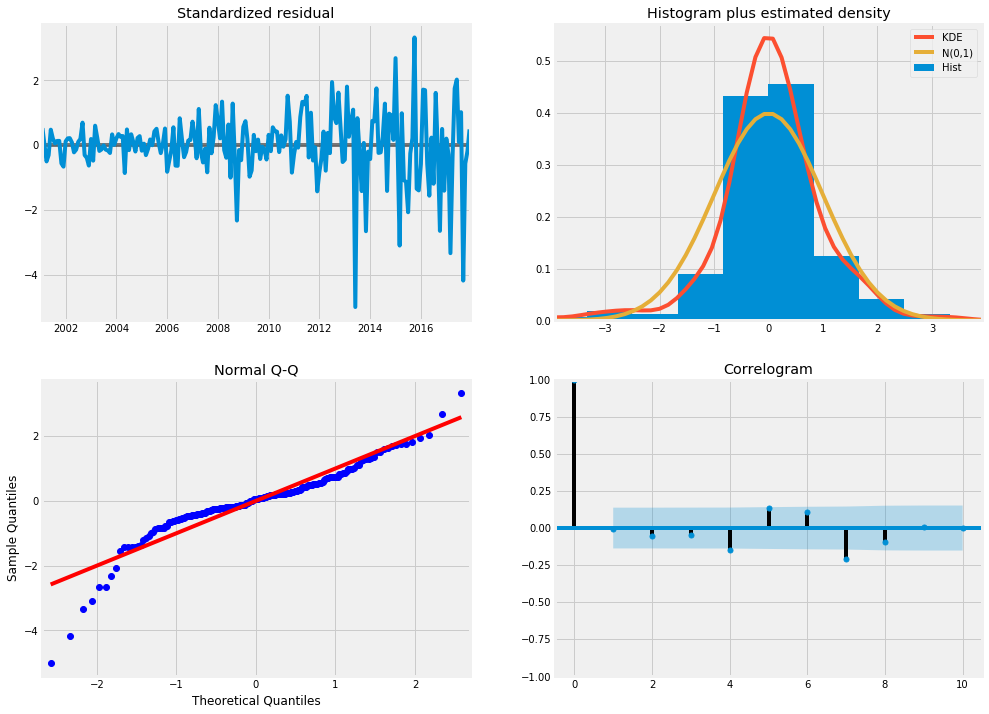

In [21]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'),dynamic=False)
pred_ci = pred.conf_int()

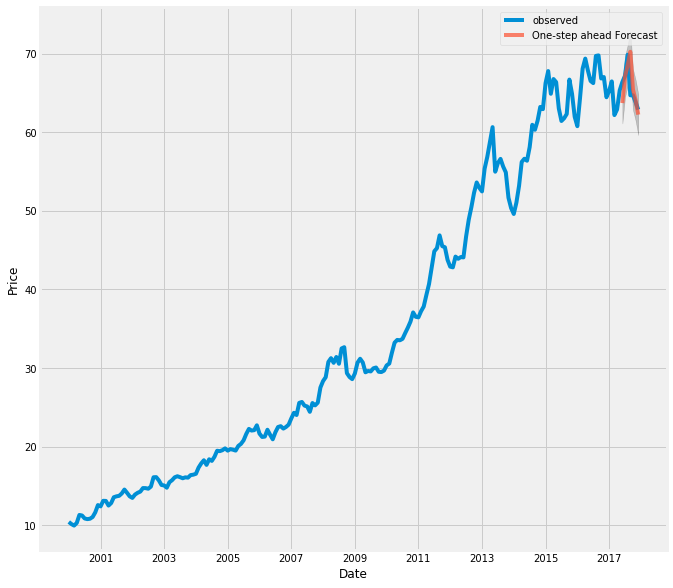

In [23]:
#plot prediction results

plt.figure(figsize =(10,10))
ax = data['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [24]:
#Calculate mean squared error

data_forecasted = pred.predicted_mean
data_truth = data['2000-01-04':]

# Compute the mean square error
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5.8


In [25]:
# Get forecast 10 steps ahead in future
pred_uc = results.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha = 0.05)
print(pred_ci)

            lower Adj Close  upper Adj Close
2018-01-01        60.567612        65.750061
2018-02-01        61.358636        69.199688
2018-03-01        61.334775        71.138162
2018-04-01        62.060762        73.494516
2018-05-01        61.176521        74.035566
2018-06-01        58.980658        73.122063
2018-07-01        58.563484        73.880261
2018-08-01        60.054348        76.462515
2018-09-01        59.344859        76.776218
2018-10-01        58.931793        77.329526


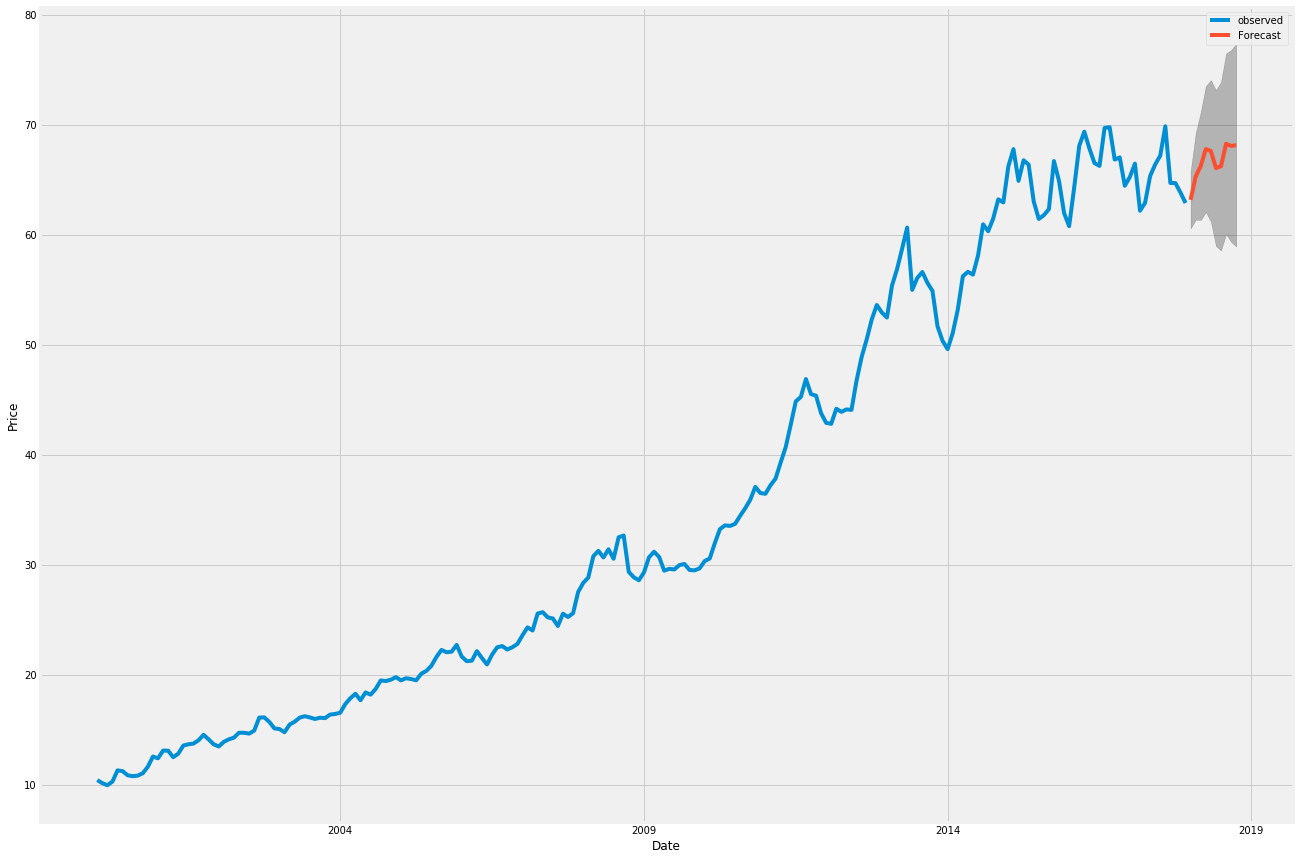

In [26]:
#Plot forecast
ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()